In [1]:
import tensorflow as tf 

In [5]:
datasets = tf.data.Dataset.range(10)
for val in datasets:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [8]:
datasets = tf.data.Dataset.range(10)
datasets = datasets.window(5, shift = 1)
for win in datasets:
    for val in win:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [9]:
datasets = tf.data.Dataset.range(10)
datasets = datasets.window(5, shift = 1, drop_remainder= True)
for win in datasets:
    for val in win:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [12]:
datasets = tf.data.Dataset.range(10)
datasets = datasets.window(5, shift = 1, drop_remainder= True)
'''for win in datasets:
    for val in win:
        print(val.numpy(), end=" ")
    print()'''
datasets = datasets.flat_map(lambda window : window.batch(5))
for win in datasets:
    print(win.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [14]:
datasets = tf.data.Dataset.range(10)
datasets = datasets.window(5, shift = 1, drop_remainder= True)
'''for win in datasets:
    for val in win:
        print(val.numpy(), end=" ")
    print()'''
datasets = datasets.flat_map(lambda window : window.batch(5))
datasets = datasets.map(lambda window : (window[:-1], window[-1:]))
for x,y in datasets:
    print(x.numpy(),y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [19]:
datasets = tf.data.Dataset.range(10)
datasets = datasets.window(5, shift = 1, drop_remainder= True)
'''for win in datasets:
    for val in win:
        print(val.numpy(), end=" ")
    print()'''
datasets = datasets.flat_map(lambda window : window.batch(5))
datasets = datasets.map(lambda window : (window[:-1], window[-1:]))
datasets = datasets.shuffle(buffer_size=10)
for x,y in datasets:
    print(x.numpy(),y.numpy())

[3 4 5 6] [7]
[4 5 6 7] [8]
[0 1 2 3] [4]
[2 3 4 5] [6]
[1 2 3 4] [5]
[5 6 7 8] [9]


In [22]:
datasets = tf.data.Dataset.range(10)
datasets = datasets.window(5, shift = 1, drop_remainder= True)
'''for win in datasets:
    for val in win:
        print(val.numpy(), end=" ")
    print()'''
datasets = datasets.flat_map(lambda window : window.batch(5))
datasets = datasets.map(lambda window : (window[:-1], window[-1:]))
datasets = datasets.shuffle(buffer_size=10)
datasets = datasets.batch(2).prefetch(1)
for x,y in datasets:
    print(x.numpy(),y.numpy())

[[2 3 4 5]
 [1 2 3 4]] [[6]
 [5]]
[[4 5 6 7]
 [3 4 5 6]] [[8]
 [7]]
[[5 6 7 8]
 [0 1 2 3]] [[9]
 [4]]


NEURAL NETWORK TRAINING

In [30]:
import numpy as np

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [31]:
def window_dataset(series, window_size, buffer_size, shuffle_buffer):
    datasets = tf.data.Dataset.from_tensor_slices(series)
    datasets = datasets.window(window_size + 1, shift=1, drop_remainder= True)
    datasets = datasets.flat_map(lambda window : window.batch(window_size + 1))
    datasets = datasets.shuffle(shuffle_buffer).map(lambda window : (window[:-1], window[-1]))
    datasets = datasets.batch(2).prefetch(1)
    return datasets

In [32]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = time[split_time:]

In [33]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [34]:
datasets = window_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [35]:
temp = tf.keras.layers.Dense(1, input_shape = [window_size])

In [36]:
model = tf.keras.models.Sequential([temp])

In [37]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [38]:
model.fit(
    datasets,
    epochs=100,
    verbose=1
)

Epoch 1/100
721/721 [==============================] - 1s 1ms/step - loss: 124.3344
Epoch 2/100
721/721 [==============================] - 1s 1ms/step - loss: 83.1566
Epoch 3/100
721/721 [==============================] - 1s 1ms/step - loss: 69.9798
Epoch 4/100
721/721 [==============================] - 1s 1ms/step - loss: 71.8901
Epoch 5/100
721/721 [==============================] - 1s 1ms/step - loss: 61.3689
Epoch 6/100
721/721 [==============================] - 1s 1ms/step - loss: 59.7664
Epoch 7/100
721/721 [==============================] - 1s 1ms/step - loss: 57.5092
Epoch 8/100
721/721 [==============================] - 1s 960us/step - loss: 59.9057
Epoch 9/100
721/721 [==============================] - 1s 957us/step - loss: 60.6610
Epoch 10/100
721/721 [==============================] - 1s 944us/step - loss: 59.0359
Epoch 11/100
721/721 [==============================] - 1s 1ms/step - loss: 69.1207
Epoch 12/100
721/721 [==============================] - 1s 1ms/step - loss: 63

In [39]:
print("Layer weights {}".format(temp.get_weights()))

Layer weights [array([[-0.02746488],
       [-0.03975791],
       [ 0.02755418],
       [-0.01865245],
       [ 0.05526684],
       [-0.03917708],
       [ 0.01164001],
       [ 0.01683582],
       [ 0.02247357],
       [ 0.00131373],
       [ 0.00606002],
       [ 0.03334491],
       [-0.03343702],
       [ 0.03985035],
       [ 0.03175322],
       [ 0.02686582],
       [ 0.03139866],
       [ 0.19381909],
       [ 0.26515403],
       [ 0.4094789 ]], dtype=float32), array([0.19677953], dtype=float32)]


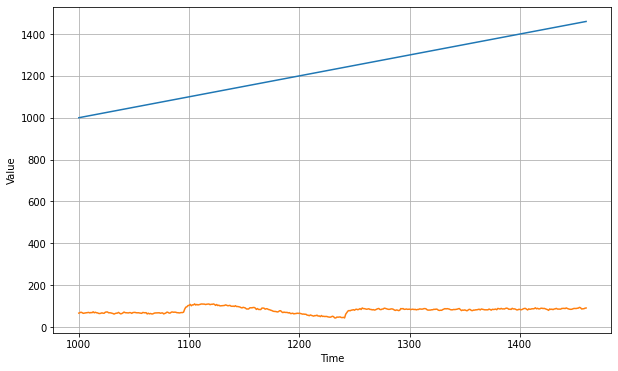

In [42]:
import matplotlib.pyplot as plt

forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1150.4443